# # Building an Intra-Population Model (IPM) - SEIR

This Jupyter notebook demonstrates how one can build there own IPM. For this demonstration we will be building an SEIR model.

## SEIR Model Overview

The SEIR model is a widely used epidemiological model that extends the SIR model by including an exposed (E) compartment. This compartment represents individuals who have been exposed to the infectious agent but are not yet infectious themselves. The SEIR model divides the population into four compartments:

1.  **Susceptible (S):** Individuals who are susceptible to the disease and can become exposed.

2.  **Exposed (E):** Individuals who have been exposed to the infectious agent but are not yet infectious.

3.  **Infectious (I):** Individuals who are currently infected and can transmit the disease to susceptible individuals.

4.  **Recovered (R):** Individuals who have recovered from the disease and are now immune.


## SEIR Model Differential Equations

The SEIR model consists of the following differential equations:

$$
\frac{{dS}}{{dt}} = -\beta S I
$$

$$
\frac{{dE}}{{dt}} = \beta S  I - \sigma E
$$

$$
\frac{{dI}}{{dt}} = \sigma E - \gamma I
$$

$$
\frac{{dR}}{{dt}} = \gamma I
$$

## Specifying Compartments and Attributes

Before you can build your Intra-population Model (IPM), you need to define the compartments and attributes that will represent the different elements of your model. In this example, we use the SEIR model, which consists of four compartments (S, E, I, R) and three attributes (beta, sigma, gamma).

### Compartments

Compartments represent the distinct groups within your population. In the SEIR model:

- "S" represents the number of susceptible individuals.
- "E" represents the number of exposed individuals.
- "I" represents the number of infectious individuals.
- "R" represents the number of recovered individuals.

You can specify your own compartment names depending on your model.

### Attributes

Attributes are parameters or variables that affect the transitions between compartments. In the SEIR model, we have three attributes:

- "beta" represents the transmission rate, which controls how individuals move from the susceptible (S) to exposed (E) state.
- "sigma" represents the rate of progression from exposed (E) to infectious (I).
- "gamma" represents the rate of recovery from infectious (I) to recovered (R).

You can define your attributes based on the parameters relevant to your model.

### Creating Symbols

To work with compartments and attributes in your IPM, you can create symbols using the `create_symbols` function. This function will generate symbolic representations of your compartments and attributes, making it easier to define transitions and equations in your IPM.

In our example, we use the following code to create symbols:

```python
symbols = create_symbols(
    compartments=[
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R'),
    ],
    attributes=[
        param('beta', shape=Shapes.TxN),  # infectivity
        param('sigma', shape=Shapes.TxN),  # progression from exposed to infected
        param('gamma', shape=Shapes.TxN)  # progression from infected to recovered
    ])
```

## Defining Transitions

Transitions describe how individuals move between compartments based on the model's dynamics. In the SEIR model, we have three transitions:

1. **Transition from "S" to "E":**
   - Controlled by the attribute "beta."
   - Rate of transition: $\beta S I / N$
   - Represents the movement from susceptible to exposed due to infectious contacts.

2. **Transition from "E" to "I":**
   - Controlled by the attribute "sigma."
   - Rate of transition: $\sigma E$
   - Represents the progression from exposed to infectious.

3. **Transition from "I" to "R":**
   - Controlled by the attribute "gamma."
   - Rate of transition: $\gamma I$
   - Represents the recovery from infectious to recovered.

You can define your transitions based on the specific dynamics of your model. The `edge` function is used to create these transitions in your IPM.

In our example, we define transitions in the SEIR model as follows:

```python
seir = create_model(
    symbols=symbols,
    transitions=[
        edge(S, E, rate=β * S * I / N),
        edge(E, I, rate=σ * E),
        edge(I, R, rate=γ * I)
    ])
```

Here, we use the symbols created earlier (S, E, I, R, beta, sigma, gamma) to specify the compartments involved in each transition and the associated transition rates. The transitions describe how individuals flow between these compartments over time.

By following these steps, you can define the compartments, attributes, and transitions in your IPM, allowing you to create a detailed model of your population's dynamics.

You can now include this Markdown content in your Jupyter notebook to provide detailed information on defining transitions in your IPM.

## Running a "Simple SEIR" Model with Pei Movement Model and Pei Geography

This Jupyter notebook presents usage examples for features of `epymorph`.

## Basic usage

Start by constructing a simulation by combining a GEO (Geography), IPM, and MM (Movement Model). If the modules are registered in the data library, it's straightforward to import them. Once you have a Simulation, you can call the run method to generate the simulation's output.

In [16]:
from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation

# Note: the 'library' dictionaries contain functions to load the named components.
# The 'pei' model family (IPM/MM/GEO) implements an SIRS model in 6 US states.
# You can mix-and-match the models!

sim = Simulation(
    geo=geo_library["pei"](),
    ipm_builder=ipm_library["seirs"](),
    mvm_builder=mm_library["pei"](),
)

Now that you have a simulation, you can call the `run` method to simulate the model for a set of input parameters. Note that it's perfectly legal to call `run` repeatedly, say for example, if you wanted to see how the output changes as you vary the parameters.

Which parameters do you need to supply? Each IPM and each MM define the parameters that they need to operate. At the moment, you'll have to inspect each of those to know for sure. (But this is something we hope to improve in the future.) There's no harm in providing extra, unused parameters, but if you are missing any you'll get an error.

We should also provide an initializer function. This specifies how the initial population compartments are set up. There is a set of pre-baked initialization routines in `epymorph.initializer`, or you're free to write your own. Here, we use the `single_location` initializer and use partial function application to set its parameters.

Here we are using the `seirs` ipm available in the epymorph library and are setting the xi parameter to zero, this ensures that their is not transmission happening from the R compartment to the S compartment.

In [17]:
out = sim.run(
    param={
        "beta": 0.5,
        "sigma": 0.01,
        "gamma": 0.02,
        "move_control": 0.9,
        "theta": 0.1,
        "xi": 0.0,
    },
    start_date=date(2023, 9, 13),
    duration_days=365,
    initializer=partial(single_location, location=0, seed_size=10_000),
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(1),
)

The output object contains time-series prevalence (compartment) and incidence (event occurrence) data for each population in the GEO, along with simulation metadata. You can access and analyze the results.

For instance, to print the SEIRS compartments for the first population and first four time steps:

In [18]:
# We can access the results directly, say by printing out the SEIRS compartments
# for the the first population and first four timesteps.
print(out.prevalence[0:4, 0, :])

[[18798958     9959       32        0]
 [18801301     9917       92        0]
 [18798625     9885      132        0]
 [18801223     9894      191        2]]


The prevalence data is a 3-dimensional numpy array, and incidence data is similar but with different dimensions.

You can also visualize the data over time using functions like plot_event and plot_pop from epymorph.run.

Include these code snippets in your notebook to analyze and visualize the simulation results.

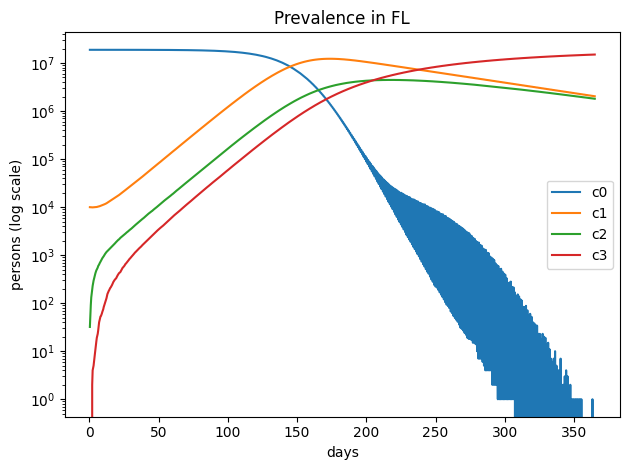

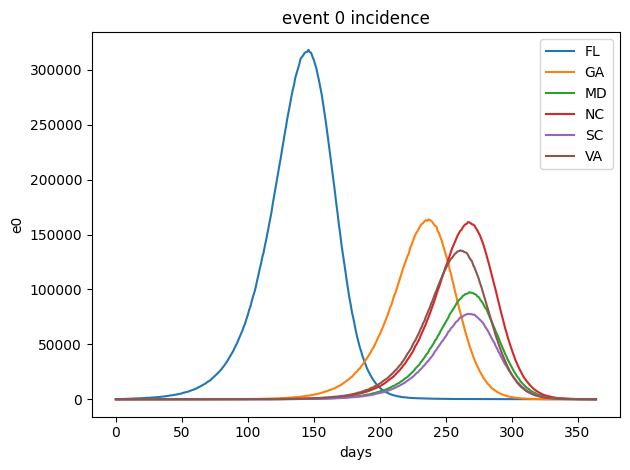

In [19]:
from epymorph.run import plot_event, plot_pop

plot_pop(out, 0)  # prevalence for all compartments in population 0.

plot_event(out, 0)  # incidence data for the S->E event across all populations.

# Building an Intra-Population Model (IPM) - SEIRS Model

This Jupyter notebook demonstrates how to create your own IPM using the "epymorph" package, focusing on an SEIRS model.

## SEIRS Model Overview

The SEIRS model is a variant of the SEIR model, used in epidemiology to describe the spread of infectious diseases. It extends the SEIR model by introducing a "Susceptible-Exposed-Infectious-Recovered-Susceptible" structure. This model includes five compartments:

1. **Susceptible (S):** Individuals who are susceptible to the disease but not yet exposed.
2. **Exposed (E):** Individuals who have been exposed to the infectious agent but are not yet infectious themselves.
3. **Infectious (I):** Individuals who are currently infected and can transmit the disease to susceptible individuals.
4. **Recovered (R):** Individuals who have recovered from the disease and are now immune.
5. **Susceptible (S):** Individuals who can become susceptible again after losing immunity.

## SEIRS Model Differential Equations

The SEIRS model is described by a set of differential equations:

$$
\frac{{dS}}{{dt}} = -\beta S I + \xi R
$$

$$
\frac{{dE}}{{dt}} = \beta S I - \sigma E
$$

$$
\frac{{dI}}{{dt}} = \sigma E - \gamma I
$$

$$
\frac{{dR}}{{dt}} = \gamma I - \xi R
$$

$$
\frac{{dS}}{{dt}} = \xi R
$$

Here's what each equation represents:

- $\beta$ is the transmission rate controlling the transition from susceptible to exposed.
- $\sigma$ represents the rate of progression from exposed to infectious.
- $\gamma$ is the recovery rate from infectious to recovered.
- $\xi$ is the rate at which individuals move from the recovered back to the susceptible state.

## Specifying Compartments and Attributes

To build the SEIRS IPM, you need to define the compartments and attributes that represent the different elements of your model. In this example, we use the SEIRS model, which consists of five compartments (S, E, I, R, S) and four attributes (beta, sigma, gamma, xi).

- "S" represents the number of susceptible individuals.
- "E" represents the number of exposed individuals.
- "I" represents the number of infectious individuals.
- "R" represents the number of recovered individuals.
- "S" represents the number of susceptible individuals who have lost immunity.

You can define your own compartment names depending on your specific model.

### Creating Symbols

To work with compartments and attributes in your SEIRS IPM, you can create symbols using the `create_symbols` function. This function generates symbolic representations of your compartments and attributes, making it easier to define transitions and equations in your IPM.

In our example, we use the following code to create symbols:

```python
symbols = create_symbols(
    compartments=[
        compartment('S'),
        compartment('E'),
        compartment('I'),
        compartment('R')
    ],
    attributes=[
        param('beta', shape=Shapes.TxN),
        param('sigma', shape=Shapes.TxN),
        param('gamma', shape=Shapes.TxN),
        param('xi', shape=Shapes.TxN)
    ])


## Defining Transitions

Transitions describe how individuals move between compartments based on the model's dynamics. In the SEIRS model, we have five transitions:

1. **Transition from "S" to "E":**
   - Controlled by the attribute "beta."
   - Rate of transition: $\beta S I$
   - Represents the movement from susceptible to exposed due to infectious contacts.

2. **Transition from "E" to "I":**
   - Controlled by the attribute "sigma."
   - Rate of transition: $\sigma E$
   - Represents the progression from exposed to infectious.

3. **Transition from "I" to "R":**
   - Controlled by the attribute "gamma."
   - Rate of transition: $\gamma I$
   - Represents the recovery from infectious to recovered.

4. **Transition from "R" to "S":**
   - Controlled by the attribute "xi."
   - Rate of transition: $\xi R$
   - Represents individuals losing immunity and becoming susceptible again.

Define these transitions using the `edge` function in your IPM.

we define transitions in the SEIRS model as follows:

```python
seirs = create_model(
    symbols=symbols,
    transitions=[
        edge(S, E, rate=β * S * I),
        edge(E, I, rate=σ * E),
        edge(I, R, rate=γ * I),
        edge(R, S, rate=ξ * R)
    ])
```


## Running a "Simple SEIRS" Model with Pei Movement Model and Pei Geography

### Basic usage

In [20]:
from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation

# Note: the 'library' dictionaries contain functions to load the named components.
# The 'pei' model family (IPM/MM/GEO) implements an SIRS model in 6 US states.
# You can mix-and-match the models!

sim1 = Simulation(
    geo=geo_library["pei"](),
    ipm_builder=ipm_library["seirs"](),
    mvm_builder=mm_library["pei"](),
)

out1 = sim.run(
    param={
        "beta": 0.5,
        "sigma": 0.01,
        "gamma": 0.02,
        "move_control": 0.9,
        "theta": 0.1,
        "xi": 1 / 90,
    },
    start_date=date(2023, 9, 13),
    duration_days=365,
    initializer=partial(single_location, location=0, seed_size=10_000),
    # I've provided a seeded RNG here just to keep this notebook's results consistent,
    # but the rng param is optional! If not given, a new RNG is constructed for each run
    # using numpy's default_rng.
    rng=np.random.default_rng(1),
)

In [21]:
# We can access the results directly, say by printing out the SEIRS compartments
# for the the first population and first four timesteps.
print(out1.prevalence[0:4, 0, :])

[[18799126     9952       36        0]
 [18801295     9916       99        0]
 [18799230     9874      142        0]
 [18801232     9855      223        0]]


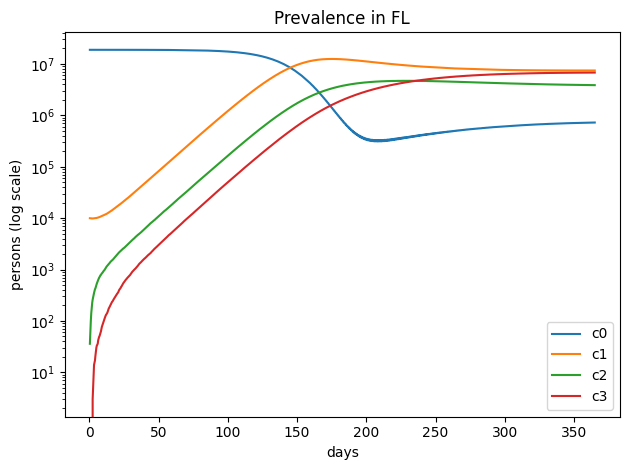

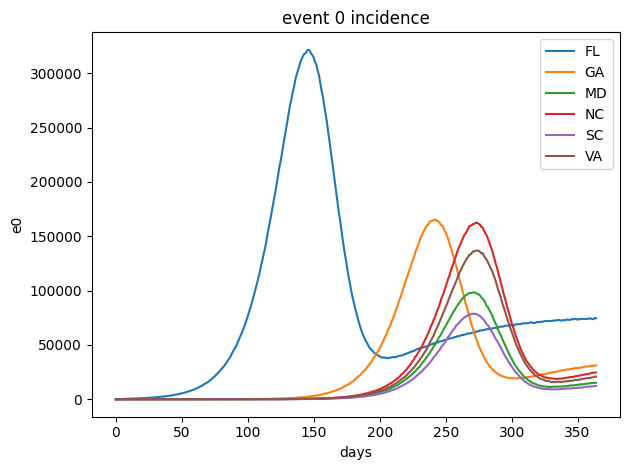

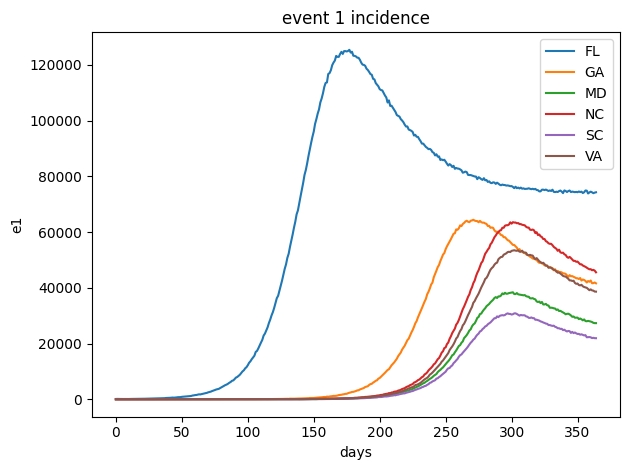

In [22]:
from epymorph.run import plot_event, plot_pop

plot_pop(out1, 0)  # prevalence for all compartments in population 0.

plot_event(out1, 0)  # incidence data for the S->E event across all populations.

plot_event(out1, 1)  # incidence data for the E->I event across all populations.